In [1]:
import numpy as np
import Scripts.meta_resnet as mrn
import Scripts.wake_processing as wp
import importlib
import Scripts.autoencoder as ae
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from math import ceil
%matplotlib inline

In [2]:
importlib.reload(mrn)
importlib.reload(wp)

<module 'Scripts.wake_processing' from 'E:\\Studies\\Deep Water\\DeepWater\\Scripts\\wake_processing.py'>

In [3]:
RS = 45
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training Data

In [4]:
real_wakes_data = np.load("Data\\Wake data\\confirmed_wakes.npy")
generated_wakes = np.load("Data\\Wake data\\generated_wakes_1000.npy")
not_wakes_day_data = np.load("Data\\Wake data\\negative_samples_3000_day.npy")
not_wakes_all_data = np.load("Data\\Wake data\\negative_samples_3000.npy")
clean_negative_samples = np.load("Data\\Wake data\\clean_negative_samples.npy")
clean_positive_samples  = np.load("Data\\Wake data\\clean_positive_samples.npy")
real_wakes = real_wakes_data[:,:,:-1,:]
not_wakes = not_wakes_day_data[:,:,:-1,:]
not_wakes_all = not_wakes_day_data[:,:,:-1,:]

## The tiny clean dataset

In [5]:
tiny_real = clean_positive_samples[:,:,:,:]

In [6]:
tiny_negative = []
for i in [15, 17, 19, 21, 26]:
    tiny_negative.append(clean_negative_samples[i,:,:-1,:])
tiny_negative = np.array(tiny_negative)

In [7]:
tiny_frames = np.append(tiny_real, tiny_negative, axis = 0)
tiny_pos_y = np.concatenate((np.ones(5).reshape(-1,1), np.zeros(5).reshape(-1,1)), axis = 1)
tiny_neg_y = np.concatenate((np.zeros(5).reshape(-1,1), np.ones(5).reshape(-1,1)), axis = 1)
tiny_labels = np.append(tiny_pos_y, tiny_neg_y, axis = 0)
tiny_X = torch.tensor(tiny_frames).float().to(device)
tiny_y = torch.tensor(tiny_labels).float().to(device)

## Train function

In [8]:
def train_weights(net, train_data, test_data, num_epochs=5, batch_size=5,  learning_rate=1e-3):
    net = net.to(device)
    opt = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)
    criterion = nn.BCELoss(reduction = 'none')
    criterion_mean = nn.BCELoss(reduction = 'mean')
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=0, drop_last=True)
    X_val, y_val = test_data.tensors[0].to(device), test_data.tensors[1].to(device)
    train_losses = []
    val_losses = []
    val_accs = []
    train_accs= []
    
    for epoch in range(num_epochs):
        total_loss = []
        batch_accs = []
        for i, (X, y) in enumerate(train_loader):
            net.train()
            X = X.to(device)
            y = y.to(device)
            
            
            meta_net = mrn.ResNet18().to(device)
            meta_net.load_state_dict(net.state_dict())
            # Lines 4 - 5 initial forward pass to compute the initial weighted loss
            
            y_f_hat  = meta_net(X)
            cost = criterion(y_f_hat,y)
            eps = torch.zeros(cost.size()).to(device)
            eps.requires_grad = True
            l_f_meta = torch.sum(cost * eps)
            meta_net.zero_grad()
            
            
             # Line 6 perform a parameter update
            grads = torch.autograd.grad(l_f_meta, (meta_net.parameters()), create_graph=True)
            meta_net.update_params(learning_rate, source_params=grads)

            # Line 8 - 10 2nd forward pass and getting the gradients with respect to epsilon
            y_g_hat = meta_net(tiny_X)

            l_g_meta = criterion_mean(y_g_hat,tiny_y)

            grad_eps = torch.autograd.grad(l_g_meta, eps, only_inputs=True)[0]
            
            # Line 11 computing and normalizing the weights
        
            w_tilde = torch.clamp(-grad_eps,min=0)
            norm_c = torch.sum(w_tilde)

            if norm_c != 0:
                w = w_tilde / norm_c
            else:
                w = w_tilde

            # Lines 12 - 14 computing for the loss with the computed weights
            # and then perform a parameter update
            y_f_hat = net(X)
            cost = criterion(y_f_hat,y)
            l_f = torch.sum(cost * w)

            train_pred_label = 1 - torch.argmax(y_f_hat, dim = 1).cpu().detach().numpy()
            train_true_label = 1 - torch.argmax(y, dim = 1).cpu().detach().numpy()
            batch_acc = accuracy_score(train_true_label, train_pred_label)
            batch_accs.append(batch_acc)
            total_loss.append(torch.mean(cost).cpu().detach().numpy())
            
            opt.zero_grad()
            l_f.backward()
            opt.step()
            
            
        #Checking accuracy/loss
        net.eval()
        
        train_loss = sum(total_loss)/len(total_loss)
        train_acc = sum(batch_accs)/len(batch_accs)
        val_pred = net(X_val)
        val_pred_label = 1 - torch.argmax(val_pred, dim = 1).cpu().detach().numpy()
        val_true_label = 1 - torch.argmax(y_val, dim = 1).cpu().detach().numpy()
        val_loss = criterion_mean(val_pred, y_val).item()
        val_acc = accuracy_score(val_true_label, val_pred_label)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        train_accs.append(train_acc)
        print('Epoch:{}, Loss:{:.4f}, Val Loss:{:.4f}, Train Acc:{:.4f}, Val Acc:{:.4f}'.format(epoch+1, train_loss,
                                                                                           val_loss, train_acc, val_acc))
    return train_losses, val_losses, train_accs, val_accs

In [9]:
def smooth_prediction(x, net, sigma, num = 500, batch_size = 10):
    net.eval()
    x = torch.tensor(x).float()
    with torch.no_grad():
        counts = np.zeros(2, dtype=int)
        for _ in range(ceil(num / batch_size)):
            this_batch_size = min(batch_size, num)
            num -= this_batch_size
            batch = x.repeat((this_batch_size, 1, 1, 1)).to(device)
            noise = torch.randn_like(batch, device=device) * sigma
            noisy_batch = batch + noise
            b_max = noisy_batch.max()
            b_min = noisy_batch.min()
            noisy_batch = (noisy_batch - b_min)/(b_max-b_min)
            predictions = net(noisy_batch).argmax(1)   
            counts_update = np.zeros(2, dtype=int)
            for idx in predictions.cpu().numpy():
                counts[idx] += 1
            counts += counts_update
        pred = counts.argmax() 
    return pred

In [10]:
def make_plots(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, label = 'Train loss')
    plt.plot(val_losses, label = 'Validation loss')
    plt.legend(loc = 'upper left')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Cross-entropy loss')
    plt.show()
    plt.figure(figsize=(10,6))
    plt.plot(train_accs, label = 'Train accuracy')
    plt.plot(val_accs, label = 'Validation accuracy')
    plt.legend(loc = 'upper left')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

In [11]:

num_epochs = 25

## Experiment: Randomized Smoothing model
### Training: 500 positive (113 real + 387 generated) and 500 negative 
### Test: 75 positive (29 real + 46 generated) and 75 negative

In [12]:
train_real, test_real = train_test_split(real_wakes, test_size=0.2, random_state=RS)
train_gen, test_gen = train_test_split(generated_wakes, train_size = 0.387, test_size=0.046, random_state=RS)
train_neg, test_neg = train_test_split(not_wakes, train_size = 1/6, test_size = 75/3000, random_state = RS)

In [13]:
test_pos = np.append(test_real, test_gen, axis = 0)
train_pos = np.append(train_real, train_gen, axis = 0)
test_x = np.append(test_pos, test_neg, axis = 0)
train_x = np.append(train_pos, train_neg, axis = 0)
test_pos_y = np.concatenate((np.ones(test_pos.shape[0]).reshape(-1,1), np.zeros(test_pos.shape[0]).reshape(-1,1)), axis = 1)
test_neg_y = np.concatenate((np.zeros(test_neg.shape[0]).reshape(-1,1), np.ones(test_neg.shape[0]).reshape(-1,1)), axis = 1)
train_pos_y = np.concatenate((np.ones(train_pos.shape[0]).reshape(-1,1), np.zeros(train_pos.shape[0]).reshape(-1,1)), axis = 1)
train_neg_y = np.concatenate((np.zeros(train_neg.shape[0]).reshape(-1,1), np.ones(train_neg.shape[0]).reshape(-1,1)), axis = 1)
test_y = np.append(test_pos_y, test_neg_y, axis = 0)
train_y = np.append(train_pos_y, train_neg_y, axis = 0)

In [14]:
train_dataset = TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
test_dataset = TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))

In [15]:
resnet_1 = None
resnet_1 = mrn.ResNet18()
train_losses, val_losses, train_accs, val_accs = train_weights(resnet_1, train_dataset, test_dataset, num_epochs = num_epochs, learning_rate=1e-4)

Epoch:1, Loss:0.3974, Val Loss:0.2533, Train Acc:0.8420, Val Acc:0.9067
Epoch:2, Loss:0.2507, Val Loss:0.2052, Train Acc:0.9040, Val Acc:0.9333
Epoch:3, Loss:0.2815, Val Loss:0.2221, Train Acc:0.8860, Val Acc:0.9200
Epoch:4, Loss:0.2950, Val Loss:0.2977, Train Acc:0.9010, Val Acc:0.8933
Epoch:5, Loss:0.2689, Val Loss:0.4343, Train Acc:0.9130, Val Acc:0.8467
Epoch:6, Loss:0.3117, Val Loss:0.2331, Train Acc:0.8930, Val Acc:0.9133
Epoch:7, Loss:0.1967, Val Loss:0.2268, Train Acc:0.9320, Val Acc:0.9200
Epoch:8, Loss:0.1868, Val Loss:0.1726, Train Acc:0.9420, Val Acc:0.9467
Epoch:9, Loss:0.2647, Val Loss:0.3200, Train Acc:0.9000, Val Acc:0.8867
Epoch:10, Loss:0.1723, Val Loss:0.2580, Train Acc:0.9450, Val Acc:0.9400
Epoch:11, Loss:0.2132, Val Loss:0.3222, Train Acc:0.9250, Val Acc:0.9000
Epoch:12, Loss:0.3329, Val Loss:0.4093, Train Acc:0.9020, Val Acc:0.8733
Epoch:13, Loss:0.3920, Val Loss:0.3847, Train Acc:0.9000, Val Acc:0.8933
Epoch:14, Loss:0.3343, Val Loss:0.1436, Train Acc:0.9130, Va

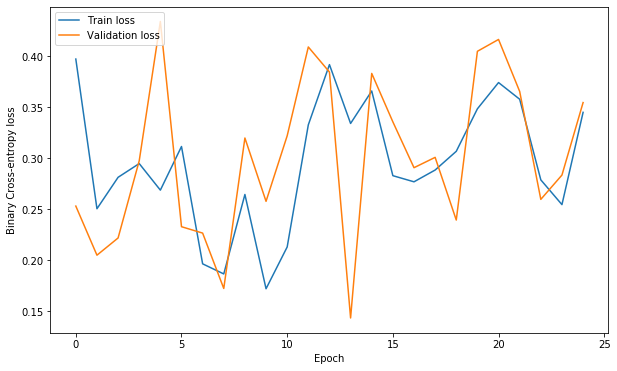

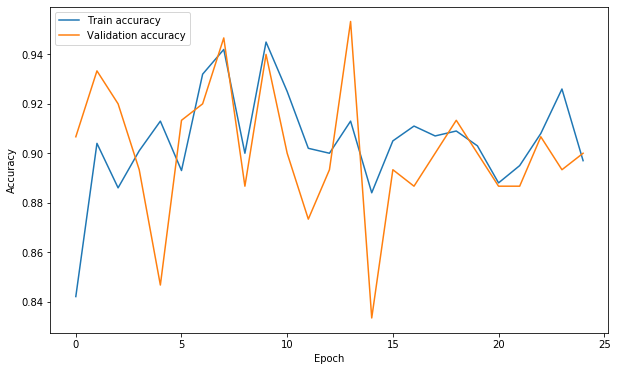

In [16]:
make_plots(train_losses, val_losses, train_accs, val_accs)

## Experiment: Smoothing with normal test data
### Training: 500 positive (113 real + 387 generated) and 500 negative 
### Test: 75 positive (29 real + 46 generated) and 75 negative

In [17]:
correct_predictions = test_y.argmax(1)

In [18]:
sigma = 0.3
smooth_predictions = []
for frame in test_x:
    smooth_predictions.append(smooth_prediction(frame, resnet_1, sigma = sigma))
smooth_predictions = np.array(smooth_predictions)
print("Sigma = 0.3, Test Accuracy: {:.4}".format(accuracy_score(correct_predictions, smooth_predictions)))

Sigma = 0.3, Test Accuracy: 0.5067


In [19]:
sigma = 0.25
smooth_predictions = []
for frame in test_x:
    smooth_predictions.append(smooth_prediction(frame, resnet_1, sigma = sigma))
smooth_predictions = np.array(smooth_predictions)
print("Sigma = 0.25, Test Accuracy: {:.4}".format(accuracy_score(correct_predictions, smooth_predictions)))

Sigma = 0.25, Test Accuracy: 0.5133


In [20]:
sigma = 0.2
smooth_predictions = []
for frame in test_x:
    smooth_predictions.append(smooth_prediction(frame, resnet_1, sigma = sigma))
smooth_predictions = np.array(smooth_predictions)
print("Sigma = 0.2, Test Accuracy: {:.4}".format(accuracy_score(correct_predictions, smooth_predictions)))

Sigma = 0.2, Test Accuracy: 0.5267


In [21]:
sigma = 0.15
smooth_predictions = []
for frame in test_x:
    smooth_predictions.append(smooth_prediction(frame, resnet_1, sigma = sigma))
smooth_predictions = np.array(smooth_predictions)
print("Sigma = 0.15, Test Accuracy: {:.4}".format(accuracy_score(correct_predictions, smooth_predictions)))

Sigma = 0.15, Test Accuracy: 0.5733


In [22]:
sigma = 0.1
smooth_predictions = []
for frame in test_x:
    smooth_predictions.append(smooth_prediction(frame, resnet_1, sigma = sigma))
smooth_predictions = np.array(smooth_predictions)
print("Sigma = 0.1, Test Accuracy: {:.4}".format(accuracy_score(correct_predictions, smooth_predictions)))

Sigma = 0.1, Test Accuracy: 0.66


In [23]:
sigma = 0.085
smooth_predictions = []
for frame in test_x:
    smooth_predictions.append(smooth_prediction(frame, resnet_1, sigma = sigma))
smooth_predictions = np.array(smooth_predictions)
print("Sigma = 0.085, Test Accuracy: {:.4}".format(accuracy_score(correct_predictions, smooth_predictions)))

Sigma = 0.085, Test Accuracy: 0.68


In [24]:
sigma = 0.065
smooth_predictions = []
for frame in test_x:
    smooth_predictions.append(smooth_prediction(frame, resnet_1, sigma = sigma))
smooth_predictions = np.array(smooth_predictions)
print("Sigma = 0.05, Test Accuracy: {:.4}".format(accuracy_score(correct_predictions, smooth_predictions)))

Sigma = 0.05, Test Accuracy: 0.7


In [25]:
sigma = 0.05
smooth_predictions = []
for frame in test_x:
    smooth_predictions.append(smooth_prediction(frame, resnet_1, sigma = sigma))
smooth_predictions = np.array(smooth_predictions)
print("Sigma = 0.05, Test Accuracy: {:.4}".format(accuracy_score(correct_predictions, smooth_predictions)))

Sigma = 0.05, Test Accuracy: 0.7267


In [26]:
sigma = 0.03
smooth_predictions = []
for frame in test_x:
    smooth_predictions.append(smooth_prediction(frame, resnet_1, sigma = sigma))
smooth_predictions = np.array(smooth_predictions)
print("Sigma = 0.03, Test Accuracy: {:.4}".format(accuracy_score(correct_predictions, smooth_predictions)))

Sigma = 0.03, Test Accuracy: 0.7933


In [27]:
sigma = 0.01
smooth_predictions = []
for frame in test_x:
    smooth_predictions.append(smooth_prediction(frame, resnet_1, sigma = sigma))
smooth_predictions = np.array(smooth_predictions)
print("Sigma = 0.01, Test Accuracy: {:.4}".format(accuracy_score(correct_predictions, smooth_predictions)))

Sigma = 0.01, Test Accuracy: 0.86
